## this will be another attempt to create a budgeted M term

I think we should start with the heat budget and try to do the M term from the advective term

This should ideally be budgeted already because the internal advective terms will cancel.

In [1]:
# auto-reload edited modules
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(0, "/home/mmurakami/crios_backups/an_helper_functions")

# run the script into the current kernel (vars/functions become available)
%run -i "/home/mmurakami/crios_backups/an_helper_functions/load_packages.py"

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)
LwetC2d 146614
LwetC 4833023



## I think we should start with a very small (2x2 box and see if we can do this)

Any vertical advection should be included in the internal mixing

In [2]:
# create an array of the time steps we want to read
# use ts2dte to get december 2014
# first make an array of filenames
dt_aste = 600
startyr = 2002
endyr = 2019

# all the filenames in the system
fnames = get_fnames(dt_aste,startyr,endyr)

times = {}
times["2016"] = np.arange(1,3,1)

# the filenames we want for 2014
tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

t2 = int(tsstr[1])    # this is the averages file that we want to read from when we do budgeting

In [3]:
# we will hard code some example box with gates for now
xs = np.array([[25,26]])
ys = np.array([[525,525]])

gatei = np.nanmin(xs)
gateip1 = np.nanmax(xs)
gateip2 = np.nanmax(xs) + 1   # the eastern "gate" index for this range,  we take -advx
gatej = np.nanmin(ys)
gatejp1 = np.nanmin(ys) + 1   # the northern "gate" index we take at j+1 for -advy

In [4]:
gatej

525

(520.0, 530.0)

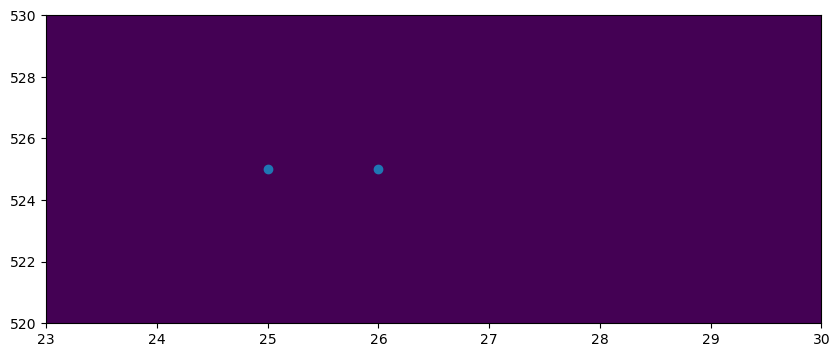

In [5]:
plt.pcolormesh(mymsk)
plt.scatter(xs,ys)
plt.xlim(23,30)
plt.ylim(520,530)

## start with the original salt budget

In [6]:
# total tendency will just be for those two squares
print("doing salt budget")
# create the salt budget
AB_gT=0
AB_gS=0
file_name = 'budg3d_snap_set2'
meta_budg3d_snap_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_snap_set2["fldList"])
varnames = np.array(["SALTDR"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])


SALTDR = np.full((len(tsstr),nz,ny,nx),np.nan)
for i in range(len(tsstr)):
    thisSALTDR,its,meta = rdmds(os.path.join(dirIn, file_name),int(tsstr[i]),returnmeta=True,rec=recs[0])
    thisSALTDR = thisSALTDR.reshape(nz,ny,nx)
    SALTDR[i] = thisSALTDR

SALTDR =  (SALTDR[1, :, :,:] - SALTDR[0, :,:, :]) / dt    # PSU.m/s

tmptend = myparms['rhoconst'] * (SALTDR - AB_gS) * mk3D_mod(RAC,SALTDR)    # kg/m^3 * PSU.m/s * m^2 = g/s
budgO = {}
budgO['saltfluxes'] = {}
budgI = {}
budgI['saltfluxes'] = {}
budgOI = {}

# ocean
budgO['saltfluxes']['tend'] = tmptend
budgO['salttend'] = np.nansum(tmptend,axis=0)

doing salt budget


In [7]:
# print the tendency for those two squares
# take the sum in the second axis to get the total tendency for this array
# we're integrating across the x axis (which is x)
stend = budgO['saltfluxes']['tend'][:,ys,xs]
stend.shape

(50, 1, 2)

In [8]:
# load the original horizontal fluxes and the hconv
file_name = "budg3d_hflux_set2"
meta_budg3d_hflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_hflux_set2["fldList"])
varnames = np.array(["ADVx_SLT","ADVy_SLT","DFxE_SLT","DFyE_SLT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVx_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
ADVy_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
DFxE_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
DFyE_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[3])

# calculate the overall horizontal convergence (we don't need here)
tmpUo = myparms['rhoconst'] * (ADVx_SLT + DFxE_SLT)
tmpVo = myparms['rhoconst'] * (ADVy_SLT + DFyE_SLT)
tmpUo = tmpUo.reshape(nz,ny,nx)
tmpVo = tmpVo.reshape(nz,ny,nx)
tmpUo = get_aste_faces(tmpUo,nfx,nfy)              
tmpVo = get_aste_faces(tmpVo,nfx,nfy)
budgO['saltfluxes']['hconv'] = calc_UV_conv_mod(nfx,nfy,tmpUo,tmpVo)
budgO['salthconv'] = calc_UV_conv_mod(nfx,nfy,np.nansum(tmpUo,axis=0),np.nansum(tmpVo,axis=0))

# also do hconv for ADV and DF
tmpUo = get_aste_faces(ADVx_SLT.reshape(nz,ny,nx),nfx,nfy)
tmpVo = get_aste_faces(ADVy_SLT.reshape(nz,ny,nx),nfx,nfy)
budgO['saltfluxes']['ADV_hconv'] = calc_UV_conv_mod(nfx,nfy,tmpUo,tmpVo) * myparms['rhoconst'] #g/s

normaladvconv = np.nansum(budgO['saltfluxes']['ADV_hconv'][:,ys,xs],axis = 2)
normaladvconv.shape

(50, 1)

In [36]:
# we need to create a new term which is the gateway transport
gatesS = np.zeros((nz,1))
tmpADVx_SLT = ADVx_SLT.reshape(nz,ny,nx)
tmpADVy_SLT = ADVy_SLT.reshape(nz,ny,nx)

# the gate hconv will just be the north and south gates
gatesS[:,0] += tmpADVx_SLT[:,gatej,gatei]     # left gate
gatesS[:,0] -= tmpADVx_SLT[:,gatej,gateip2]   # right gate
gatesS[:,0] += tmpADVy_SLT[:,gatej,gatei]     # bottom left gate
gatesS[:,0] += tmpADVy_SLT[:,gatej,gateip1]   # bottom right gate
gatesS[:,0] -= tmpADVy_SLT[:,gatejp1,gatei]   # top left gate
gatesS[:,0] -= tmpADVy_SLT[:,gatejp1,gateip1]   # top right gate

gatesS *= myparms['rhoconst']

In [11]:
tmpUo = get_aste_faces(DFxE_SLT.reshape(nz,ny,nx),nfx,nfy)
tmpVo = get_aste_faces(DFyE_SLT.reshape(nz,ny,nx),nfx,nfy)
budgO['saltfluxes']['DF_hconv'] = calc_UV_conv_mod(nfx,nfy,tmpUo,tmpVo) * myparms['rhoconst'] #g/s

# read the vars
file_name = "budg2d_hflux_set1"
meta_budg2d_hflux_set1 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg2d_hflux_set1["fldList"])
varnames = np.array(["ADVxHEFF","ADVyHEFF","DFxEHEFF","DFyEHEFF"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVxHEFF,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
ADVyHEFF,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
DFxEHEFF,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
DFyEHEFF,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[3])
ADVxHEFF = ADVxHEFF.reshape(ny,nx)
ADVyHEFF = ADVxHEFF.reshape(ny,nx)
DFxEHEFF = DFxEHEFF.reshape(ny,nx)
DFyEHEFF = DFyEHEFF.reshape(ny,nx)
    
if myparms['seaice_variable_salinity_flag'] == 0:
    SIsal0 = myparms['SIsal0']

tmpUi = SIsal0 * myparms['rhoi'] * (DFxEHEFF + ADVxHEFF)
tmpVi = SIsal0 * myparms['rhoi'] * (DFyEHEFF + ADVyHEFF)
tmpUi = get_aste_faces(tmpUi,nfx,nfy)              
tmpVi = get_aste_faces(tmpVi,nfx,nfy)

budgI['salthconv'] = calc_UV_conv_mod(nfx,nfy,tmpUi, tmpVi)
budgOI['salthconv'] = (budgO['salthconv'] + budgI['salthconv'])


# read fluxes
file_name = 'budg2d_zflux_set1'
meta_budg2d_zflux_set1 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg2d_zflux_set1["fldList"])
varnames = np.array(["oceSPflx","SFLUX"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
oceSPflx,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
SFLUX,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
oceSPflx = oceSPflx.reshape(ny,nx)
SFLUX = SFLUX.reshape(ny,nx)

# read relax and salt mass
file_name = "budg2d_zflux_set2"
meta_budg2d_zflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg2d_zflux_set2["fldList"])
varnames = np.array(["oceSflux","WSLTMASS","SRELAX"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    if len(irec[0]) > 0:
        recs = np.append(recs, irec[0][0])
oceSflux,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
WSLTMASS,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
SRELAX,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
oceSflux = oceSflux.reshape(ny,nx)
WSLTMASS = WSLTMASS.reshape(ny,nx)
SRELAX = SRELAX.reshape(ny,nx)


# read kpp tend and from 3d zflux
file_name = "budg3d_kpptend_set1"
meta_budg3d_kpptend_set1 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_kpptend_set1["fldList"])
varnames = np.array(["oceSPtnd","KPPg_SLT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    if len(irec[0]) > 0:
        recs = np.append(recs, irec[0][0])
oceSPtnd,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
KPPg_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
oceSPtnd = oceSPtnd.reshape(nz,ny,nx)
KPPg_SLT = KPPg_SLT.reshape(nz,ny,nx)


# now 3d zfluxes
file_name = "budg3d_zflux_set2"
meta_budg3d_zflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_zflux_set2["fldList"])
varnames = np.array(["ADVr_SLT","DFrE_SLT","DFrI_SLT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVr_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
DFrE_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
DFrI_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
ADVr_SLT = ADVr_SLT.reshape(nz,ny,nx)
DFrE_SLT = DFrE_SLT.reshape(nz,ny,nx)
DFrI_SLT = DFrI_SLT.reshape(nz,ny,nx)

if myparms["useRFWF"]==0 or myparms['useNLFS']==0:
    print('do nothing')
else:
    oceSflux = 0 * oceSflux

if myparms['useNLFS'] == 0:
    print('do nothing, already read above')
else:
    WSLTMASS=0*WSLTMASS

budgO['saltzconv'] = SFLUX + oceSPflx                  # W/m^2
zconv_top_salt = (SFLUX + oceSPflx) * RAC               # g/s
budgI['saltzconv'] = -budgO['saltzconv'] + SRELAX

if myparms['useNLFS']==0:
    budgO['saltzconv'] = budgO['saltzconv'] - myparms['rhoconst']*WSLTMASS

if myparms['useRFWF']==0 or myparms['useNLFS']==0:
    budgI['saltzconv']=-oceSflux


nr = mygrid['RC'].shape[0]
# break trWtop down into smaller terms
trWtopADV = -(ADVr_SLT)*myparms['rhoconst']           # g/s
trWtopDF = -(DFrE_SLT+DFrI_SLT)*myparms['rhoconst']   # g/s
trWtopKPP = -(KPPg_SLT)*myparms['rhoconst']           # g/s
trWtop = trWtopADV + trWtopDF + trWtopKPP             # g/s 

#print(trWtop.shape)
sptop = mk3D_mod(oceSPflx,oceSPtnd) - np.cumsum(oceSPtnd, axis=0)        # we include this in our zconv_top term
sptop = sptop * RAC3        # g/s

trWtop[1:,:,:] = trWtop[1:,:,:] + sptop[:-1,:,:]
trWtop[0,:,:] = budgO['saltzconv'] * RAC    # g/s top layer is surface flux

trWbot = np.zeros_like(trWtop)
trWbot[:-1,:,:] = trWtop[1:,:,:]
trWbot[-1,:,:] = 0

budgO['saltfluxes']['trWtop'] = trWtop     # g/s
budgO['saltfluxes']['trWbot'] = trWbot     # g/s

budgI['saltfluxes']['trWtop'] = -RAC*0
budgI['saltfluxes']['trWbot'] = budgO['saltfluxes']['trWtop'][0,:,:]  # surface because ice

budgO['saltfluxes']['zconv'] = budgO['saltfluxes']['trWtop'] - budgO['saltfluxes']['trWbot']
budgO['saltzconv'] = RAC * budgO['saltzconv']   # g/s
budgI['saltzconv'] = RAC * budgI['saltzconv']   # g/s
budgOI['saltzconv'] = budgO['saltzconv'] + budgI['saltzconv']

# do vertical convergence for ADV and DF terms
tmpadv = np.full((nz,ny,nx),np.nan)
tmpadv[:-1,:,:] = (trWtopADV[:-1] - trWtopADV[1:])              # for surface thru seafloor

Sconv = budgO['saltfluxes']['ADV_hconv'] + tmpadv
budgO['saltfluxes']['ADV_Sconv'] = Sconv             # g/s, this is the advective arrow of S for a 

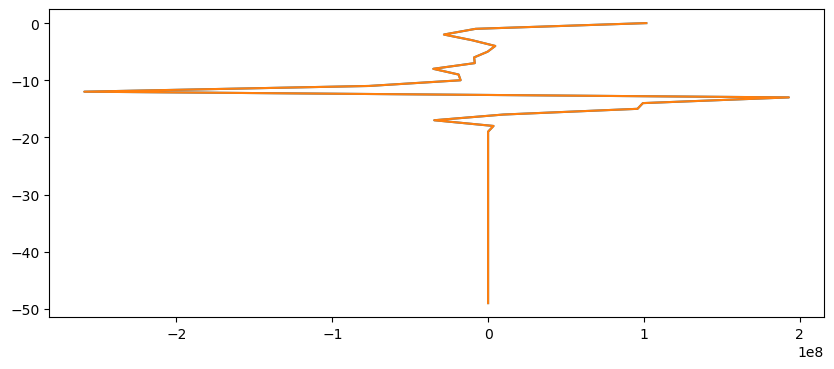

In [18]:
fig = plt.figure()
ax = plt.subplot(111)
ks = np.arange(0,-nz,-1)

# this is just redistributing heat vertically, this will not affect the overall heat budget of the column (this is zero)
zadvcol = np.nansum(tmpadv[:,ys,xs],axis=2)

ax.plot(normaladvconv[:,0],ks)   # this is the same as below
ax.plot(gatesS[:,0],ks)           # this is the same as the above
# ax.plot(zadvcol,ks)

In [13]:
# DF and KPP should be the same

# do vertical convergence for ADV and DF terms
tmpdf = np.full((nz,ny,nx),np.nan)
tmpdf[:-1,:,:] = (trWtopDF[:-1] - trWtopDF[1:])              # for surface thru seafloor

dfSconv = budgO['saltfluxes']['DF_hconv'] + tmpdf
budgO['saltfluxes']['DF_Sconv'] = dfSconv             # g/s, this is the diffusive arrow of T for a cell
dfconv = budgO['saltfluxes']['DF_Sconv'][:,ys,xs]  # I don't think we want to integrate these for the whole column


tmpkpp = np.full((nz,ny,nx),np.nan)
tmpkpp[:-1,:,:] = trWtopKPP[:-1] - trWtopKPP[1:]
budgO['saltfluxes']['KPP_Sconv'] = tmpkpp        # no horizontal component for this
kppconv = budgO['saltfluxes']['KPP_Sconv'][:,ys,xs]

In [22]:
# let's load the Tbins and the Sbins for these columns
# set for all months
vol = np.zeros((len(tsstr),nz, ny, nx))
#print("volume allocation shape",vol.shape)

for t in range(len(tsstr)):
    tmpvol = np.tile(mygrid['DXG'][np.newaxis,:,:],(50,1,1)) * np.tile(mygrid['DYG'][np.newaxis,:,:],(50,1,1)) * DRF3d

    vol[t,:,:,:] = tmpvol * np.tile(mymsk, (nz, 1, 1))
#######
print("doing TS binning")
# read theta and salt averages from the t2 timestep (average)
file_name = "state_3d_set1"
meta_budg3d_kpptend_set1 = parsemeta(dirState + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_kpptend_set1["fldList"])
varnames = np.array(["THETA","SALT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
THETA,its,meta = rdmds(os.path.join(dirState, file_name),t2,returnmeta=True,rec=recs[0])
SALT,its,meta = rdmds(os.path.join(dirState, file_name),t2,returnmeta=True,rec=recs[1])

THETA = THETA.reshape(nz,ny,nx) * np.tile(mymsk[np.newaxis,:,:],(nz,1,1))
SALT = SALT.reshape(nz,ny,nx) * np.tile(mymsk[np.newaxis,:,:],(nz,1,1))
    
copypath = "/scratch/mmurakami/ASTE_270/LAYERS_copies/"
filename = "layers2TH"
boundsT = rdmds(copypath + filename)
binsTH_edges = boundsT.reshape(boundsT.shape[0])
binsTH_centers = (binsTH_edges[:-1] + binsTH_edges[1:])/2
nT = binsTH_edges.shape[0]-1

filename = "layers1SLT"
boundsS = rdmds(copypath + filename)
binsSLT_edges = boundsS.reshape(boundsS.shape[0])
binsSLT_centers = (binsSLT_edges[:-1] + binsSLT_edges[1:])/2
nS = binsSLT_edges.shape[0]-1

binwidthT = binsTH_edges[1:] - binsTH_edges[:-1]
binwidthS = binsSLT_edges[1:] - binsSLT_edges[:-1]
dT,dS = np.meshgrid(binwidthT,binwidthS)
dT = dT.reshape(112,112,1)
dS = dS.reshape(112,112,1)

# mask the nans in each
THETA[np.isnan(mygrid['hFacC'])] = np.nan
SALT[np.isnan(mygrid['hFacC'])] = np.nan

# create the binned values for theta and salt
# we want to bin theta and salt into the T and S bins
binned_theta = bin_array(THETA,binsTH_edges)
binned_theta = binned_theta.astype(float)
binned_theta[binned_theta == nT] = np.nan     # because the binning is setting nan to last value
binned_salinity = bin_array(SALT,binsSLT_edges)
binned_salinity = binned_salinity.astype(float)
binned_salinity[binned_salinity == nS] = np.nan

doing TS binning


In [23]:
# we should be able to take the overall salt budget of this column with the gates
stend    # nz,1,2
gates    # nz,1,1  -- this is the same as the original advhconv
dfconv   # nz,1,2
kppconv  # nz,1,2
zconv_top_salttmp = zconv_top_salt[ys,xs]  # 1,2
sptoptmp = sptop[:,ys,xs]    # nz,1,2

In [24]:
# we only really care about the binned_salinity for this region
binned_salinity_col = binned_salinity[:,ys,xs]    # nz,1,2
binned_theta_col = binned_theta[:,ys,xs]

In [25]:
Sconvsel = Sconv[:,ys,xs]

In [26]:
# we're only looking at one Sbin here so maybe this will be easy
ibinS = np.nanmax(binned_salinity_col)

In [27]:
# get the non nan terms in these two columns
hfcsel = mygrid['hFacC'][:,ys,xs]
nzna = hfcsel[~np.isnan(hfcsel[:,:,0])].shape[0]
nzna

19

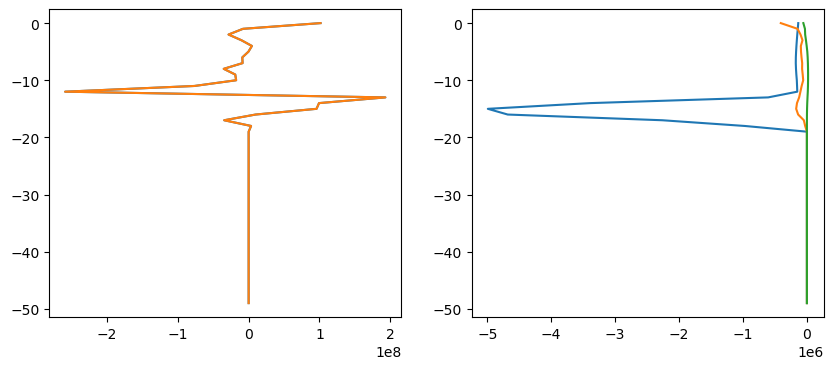

In [28]:
# we know here that normaladvconv and gates are the same

# maybe we should just plot this as a line so we can try to understand

fig = plt.figure()

ax = plt.subplot(121)

# advconv is the sum in x of these two
ax.plot(normaladvconv[:,0],ks)   # this is the same as below
ax.plot(gatesS[:,0],ks)           # this is the same as the above

ax = plt.subplot(122)
ax.plot(np.nansum(stend,axis=2),ks)
ax.plot(np.nansum(dfconv,axis=2),ks)
ax.plot(np.nansum(kppconv,axis=2),ks)

In [29]:
# we only have one Sbin so we can just make a sample J terms of one S bin
nzna = 19 # hard code for now but this is the max where drf is non na
JtermsS = np.zeros((6,1))

for pt in range(2):
    for k in range(nzna):
        iTpt = int(binned_theta_col[k,0,pt])
        iSpt = int(binned_salinity_col[k,0,pt])
        
        JtermsS[0] += stend[k,0,pt]  / myparms['rhoconst'] #/ binwidthT[iTpt] / binwidthS[iSpt] * 1e-6  # total tend
        JtermsS[2] += dfconv[k,0,pt]  / myparms['rhoconst'] #/ binwidthT[iTpt] / binwidthS[iSpt] * 1e-6  # diffusive tend
        JtermsS[3] += kppconv[k,0,pt]  / myparms['rhoconst'] #/ binwidthT[iTpt] / binwidthS[iSpt] * 1e-6  # kpp tend

        # do the advective tendency as we have done it before to see that these are the same
        JtermsS[5] += Sconvsel[k,0,pt] / myparms['rhoconst'] #/ binwidthT[iTpt] / binwidthS[iSpt] * 1e-6 
        
for k in range(nzna):
    JtermsS[1] += gatesS[k,0] / myparms['rhoconst'] #/ binwidthT[iTpt] / binwidthS[iSpt] * 1e-6 

# do the surface tendency separately
for pt in range(2):
    for k in range(nzna):
        iTpt = int(binned_theta_col[k,0,pt])
        iSpt = int(binned_salinity_col[k,0,pt])
        
        if k == 0:
            JtermsS[4] += (zconv_top_salttmp[0,pt] - sptoptmp[k,0,pt]) / myparms['rhoconst'] #/ binwidthT[iTpt] / binwidthS[iSpt] * 1e-6
        else:
            JtermsS[4] += -(sptoptmp[k,0,pt] - sptoptmp[k-1,0,pt])/ myparms['rhoconst'] #/ binwidthT[iTpt] / binwidthS[iSpt] * 1e-6

labels = np.array(["stend","gates","df","kpp","surface","original sconv"])
for i in range(6):
    print(labels[i],JtermsS[i])

In [30]:
labels = np.array(["stend","gates","df","kpp","surface","original sconv"])
for i in range(6):
    print(labels[i],JtermsS[i])

stend [-18435.88072741]
gates [1457.90825157]
df [-2052.61408147]
kpp [2.59693525e-14]
surface [-7.16474297e-15]
original sconv [1457.90825157]


In [31]:
binwidthT[17]

0.20000004768371582

In [35]:
# if we want to do this at the original T and S points, I think we need to label the gate contribution with T and S rather than summing
# we need to create a new term which is the gateway transport

# try to do the gates again with East and West specifically so we can demarcate by T and S
gatesS3 = np.zeros((nz,1,2))
tmpADVx_SLT = ADVx_SLT.reshape(nz,ny,nx)
tmpADVy_SLT = ADVy_SLT.reshape(nz,ny,nx)

# the gate hconv will just be the north and south gates
gatesS3[:,0,0] += tmpADVx_SLT[:,gatej,gatei]     # left gate
gatesS3[:,0,1] -= tmpADVx_SLT[:,gatej,gateip2]   # right gate
gatesS3[:,0,0] += tmpADVy_SLT[:,gatej,gatei]     # bottom left gate
gatesS3[:,0,1] += tmpADVy_SLT[:,gatej,gateip1]   # bottom right gate
gatesS3[:,0,0] -= tmpADVy_SLT[:,gatejp1,gatei]   # top left gate
gatesS3[:,0,1] -= tmpADVy_SLT[:,gatejp1,gateip1]   # top right gate

gatesS3 *= myparms['rhoconst']

In [33]:
# we only have one Sbin so we can just make a sample J terms of one S bin

JtermsS = np.zeros((6,1))

for pt in range(2):
    for k in range(nzna):
        iTpt = int(binned_theta_col[k,0,pt])
        iSpt = int(binned_salinity_col[k,0,pt])
        
        JtermsS[0] += stend[k,0,pt]  / myparms['rhoconst'] / binwidthT[iTpt] / binwidthS[iSpt] * 1e-6  # total tend
        JtermsS[2] += dfconv[k,0,pt]  / myparms['rhoconst'] / binwidthT[iTpt] / binwidthS[iSpt] * 1e-6  # diffusive tend
        JtermsS[3] += kppconv[k,0,pt]  / myparms['rhoconst'] / binwidthT[iTpt] / binwidthS[iSpt] * 1e-6  # kpp tend

        # do the advective tendency as we have done it before to see that these are the same
        JtermsS[5] += Sconvsel[k,0,pt] / myparms['rhoconst'] / binwidthT[iTpt] / binwidthS[iSpt] * 1e-6 

for pt in range(2):
    for k in range(nzna):
        iTpt = int(binned_theta_col[k,0,pt])
        iSpt = int(binned_salinity_col[k,0,pt])
        JtermsS[1] += gatesT[k,0,pt] / myparms['rhoconst'] / binwidthT[iTpt] / binwidthS[iSpt] * 1e-6 

# do the surface tendency separately
for pt in range(2):
    for k in range(nzna):
        iTpt = int(binned_theta_col[k,0,pt])
        iSpt = int(binned_salinity_col[k,0,pt])
        
        if k == 0:
            JtermsS[4] += (zconv_top_salttmp[0,pt] - sptoptmp[k,0,pt]) / myparms['rhoconst'] / binwidthT[iTpt] / binwidthS[iSpt] * 1e-6
        else:
            JtermsS[4] += -(sptoptmp[k,0,pt] - sptoptmp[k-1,0,pt])/ myparms['rhoconst'] / binwidthT[iTpt] / binwidthS[iSpt] * 1e-6

In [34]:
labels = np.array(["stend","gates","df","kpp","surface","original sconv"])
for i in range(6):
    print(labels[i],JtermsS[i])

stend [-0.18619339]
gates [19.62809689]
df [-0.02878795]
kpp [-9.20291317e-08]
surface [-1.06503799e-19]
original sconv [0.02278181]


In [27]:
# the above is not correct, I think we're messing something up with the divide by iTpt and iSpt

## Try the exact same thing with the heat budget to see if we can do

In [38]:
#############################################################################
print("doing heat budget")
# create the heat budget
# read thetadr
file_name = 'budg3d_snap_set2'
meta_budg3d_snap_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_snap_set2["fldList"])
varnames = np.array(["THETADR"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])

THETADR = np.full((len(tsstr),nz,ny,nx),np.nan)
for i in range(len(tsstr)):
    thisTHETADR,its,meta = rdmds(os.path.join(dirIn, file_name),int(tsstr[i]),returnmeta=True,rec=recs[0])
    thisTHETADR = thisTHETADR.reshape(nz,ny,nx)
    THETADR[i] = thisTHETADR

THETADR =  (THETADR[1, :, :,:] - THETADR[0, :,:, :]) / dt    # degC.m/

tmptend=myparms['rcp']*(THETADR-AB_gT)*mk3D_mod(RAC,THETADR)   # J/m^3.degC * degC.m/s * m^2 = J/s
budgO['heatfluxes'] = {}
budgI['heatfluxes'] = {}

budgO['heatfluxes']['tend'] = tmptend     # J/s

budgO['heattend'] = np.nansum(tmptend,axis=0)

file_name = "budg3d_hflux_set2"
meta_budg3d_hflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_hflux_set2["fldList"])
varnames = np.array(["ADVx_TH","ADVy_TH","DFxE_TH","DFyE_TH","UVELMASS","VVELMASS"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVx_TH,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
ADVy_TH,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
DFxE_TH,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
DFyE_TH,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[3])
# UVELMASS,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[4])
# VVELMASS,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[5])  # m/s

# reshape the UVELMASS and VVELMASS to look at these
# UVELMASS = UVELMASS.reshape(nz,ny,nx)
# VVELMASS = VVELMASS.reshape(nz,ny,nx)

tmpUo = myparms['rcp'] * (ADVx_TH + DFxE_TH)
tmpVo = myparms['rcp'] * (ADVy_TH + DFyE_TH)

tmpUo = tmpUo.reshape(nz,ny,nx)
tmpVo = tmpVo.reshape(nz,ny,nx)

# get the faces so we can do convergence
tmpUo = get_aste_faces(tmpUo,nfx,nfy)              
tmpVo = get_aste_faces(tmpVo,nfx,nfy)

budgO['heatfluxes']['hconv'] = calc_UV_conv_mod(nfx,nfy,tmpUo,tmpVo)
budgO['heathconv'] = calc_UV_conv_mod(nfx,nfy,np.nansum(tmpUo, axis=0),np.nansum(tmpVo,axis=0))

# add the budgeting for ADV and DF
tmpUo = get_aste_faces(ADVx_TH.reshape(nz,ny,nx),nfx,nfy)
tmpVo = get_aste_faces(ADVy_TH.reshape(nz,ny,nx),nfx,nfy)
budgO['heatfluxes']['ADV_hconv'] = calc_UV_conv_mod(nfx,nfy,tmpUo,tmpVo) * myparms['rcp'] #J/s

normaladvconv = np.nansum(budgO['heatfluxes']['ADV_hconv'][:,ys,xs],axis = 2)
normaladvconv.shape

doing heat budget


(50, 1)

In [39]:
# get the gateway transports for the ADV term

In [40]:
# we need to create a new term which is the gateway transport
gatesT = np.zeros((nz,1))
tmpADVx_TH = ADVx_TH.reshape(nz,ny,nx)
tmpADVy_TH = ADVy_TH.reshape(nz,ny,nx)

# the gate hconv will just be the north and south gates
gatesT[:,0] += tmpADVx_TH[:,gatej,gatei]     # left gate
gatesT[:,0] -= tmpADVx_TH[:,gatej,gateip2]   # right gate
gatesT[:,0] += tmpADVy_TH[:,gatej,gatei]     # bottom left gate
gatesT[:,0] += tmpADVy_TH[:,gatej,gateip1]   # bottom right gate
gatesT[:,0] -= tmpADVy_TH[:,gatejp1,gatei]   # top left gate
gatesT[:,0] -= tmpADVy_TH[:,gatejp1,gateip1]   # top right gate

gatesT *= myparms['rcp']

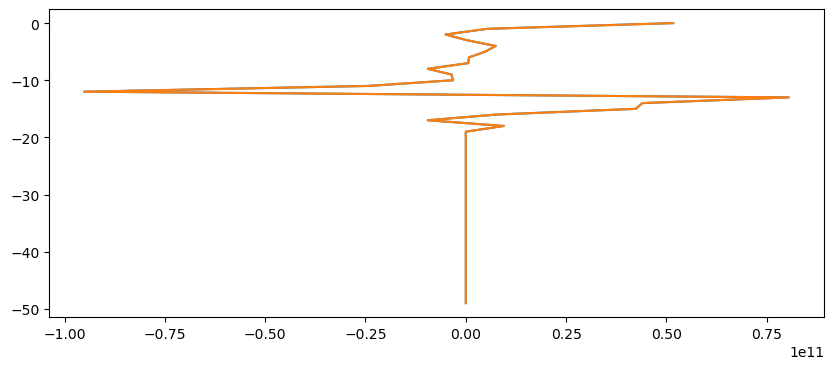

In [41]:
# show that these are the same
fig = plt.figure()
ax = plt.subplot(111)
ks = np.arange(0,-nz,-1)

# this is just redistributing heat vertically, this will not affect the overall heat budget of the column (this is zero)
zadvcol = np.nansum(tmpadv[:,ys,xs],axis=2)

ax.plot(normaladvconv[:,0],ks)   # this is the same as below
ax.plot(gatesT[:,0],ks)           # this is the same as the above

In [43]:
tmpUo = get_aste_faces(DFxE_TH.reshape(nz,ny,nx),nfx,nfy)
tmpVo = get_aste_faces(DFyE_TH.reshape(nz,ny,nx),nfx,nfy)
budgO['heatfluxes']['DF_hconv'] = calc_UV_conv_mod(nfx,nfy,tmpUo,tmpVo) * myparms['rcp'] #J/s

file_name = 'budg2d_zflux_set1'
meta_budg2d_zflux_set1 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg2d_zflux_set1["fldList"])
varnames = np.array(["TFLUX","oceQsw","SItflux"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
TFLUX,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
oceQsw,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
SItflux,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
TFLUX = TFLUX.reshape(ny,nx)
oceQsw = oceQsw.reshape(ny,nx)
SItflux = SItflux.reshape(ny,nx)

# note: the following works provided that the first 3 terms are definitely there
file_name = "budg2d_zflux_set2"
meta_budg2d_zflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg2d_zflux_set2["fldList"])
varnames = np.array(["oceQnet","WTHMASS","SIaaflux","TRELAX"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
oceQnet,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
WTHMASS,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
SIaaflux,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
TRELAX,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[3])
oceQnet = oceQnet.reshape(ny,nx)
WTHMASS = WTHMASS.reshape(ny,nx)
SIaaflux = SIaaflux.reshape(ny,nx)
TRELAX = TRELAX.reshape(ny,nx)

# note: will not work if these are defined, fix for future steps
varnames = np.array(["TRELAX","SIabflux","SIacflux","SIeprflx","SIfldflx"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    if len(irec[0]) > 0:
        recs = np.append(recs, irec[0][0])

# if len(recs) == 0:
SIabflux = np.zeros((ny, nx))
SIacflux = np.zeros((ny, nx))
SIeprflx = np.zeros((ny, nx))
SIfldflx = np.zeros((ny, nx))
if myparms['useNLFS'] == 0:
    print('do nothing, already read above')
else:
    WTHMASS=0*WTHMASS

geothFlux = 0

if myparms['SaltPlumeHeatFlux']:
    print(1)
else:
    SPforcT1=0*np.ones((ny,nx))
    oceEPtnd=0*np.ones((nz,ny,nx))


# read kpp tend and from 3d zflux
file_name = "budg3d_kpptend_set1"
meta_budg3d_kpptend_set1 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_kpptend_set1["fldList"])
varnames = np.array(["KPPg_TH"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
KPPg_TH,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
KPPg_TH = KPPg_TH.reshape(nz,ny,nx)

# now 3d zfluxes
file_name = "budg3d_zflux_set2"
meta_budg3d_zflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_zflux_set2["fldList"])
varnames = np.array(["ADVr_TH","DFrE_TH","DFrI_TH"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVr_TH,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
DFrE_TH,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
DFrI_TH,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
ADVr_TH = ADVr_TH.reshape(nz,ny,nx)
DFrE_TH = DFrE_TH.reshape(nz,ny,nx)
DFrI_TH = DFrI_TH.reshape(nz,ny,nx)

budgO['heatzconv']=TFLUX+geothFlux+SPforcT1                           # W/m^2 = J/m^2/s
zconv_top_heat = TFLUX  * RAC     # W/m^2 * m^2 = J/s
budgI['heatzconv']=-(SItflux+TFLUX-TRELAX+SPforcT1)

if myparms['useNLFS']==0:
    print(1)
    budgO['heatzconv']=budgO['heatzconv']-myparms['rcp']*WTHMASS[:,:]     # degC.m/s * J/m^3degC = J/m^2.s

budgI['heatzconv']=budgI['heatzconv']-SIabflux+SIacflux+SIeprflx
if(myparms['SEAICEheatConsFix']==0):
    print(2)
    budgI['heatzconv']=budgI['heatzconv']+SIaaflux

nr = mygrid['RC'].shape[0]
trWtopADV = -(ADVr_TH) * myparms['rcp']         # J/s
trWtopDF = -(DFrE_TH+DFrI_TH) * myparms['rcp']  # J/s
trWtopKPP = -(KPPg_TH) * myparms['rcp']         # J/s
trWtop = trWtopADV + trWtopDF + trWtopKPP       # J/s
dd = mygrid['RF'][:-1]
swfrac = 0.62*np.exp(dd/0.6)+(1-0.62)*np.exp(dd/20)
swfrac[dd < -200] = 0
swtop=mk3D_mod(swfrac,trWtop)*mk3D_mod(RAC*oceQsw,trWtop)   # J/s
mskC=mygrid['mskC']
swtop[np.isnan(mskC)]=0
trWtop=trWtop+swtop  # 323
    
trWtop[0,:,:]=budgO['heatzconv']*RAC
trWbot = np.zeros_like(trWtop)
trWbot[:-1,:,:]=trWtop[1:,:,:]

budgO["heatfluxes"]["trWtop"] = trWtop
budgO["heatfluxes"]["trWbot"] = trWbot

budgI["heatfluxes"]["trWtop"] = -RAC * (budgI["heatzconv"] + budgO["heatzconv"])
budgI["heatfluxes"]["trWbot"] = -RAC * budgO["heatzconv"]
budgO['heatfluxes']['zconv']=budgO['heatfluxes']['trWtop']-budgO['heatfluxes']['trWbot']

budgO['heatzconv'] = RAC*budgO['heatzconv']  # J/s
budgI['heatzconv']=RAC*budgI['heatzconv']    # J/s
budgOI['heatzconv']=budgO['heatzconv']+budgI['heatzconv']

# do vertical convergence for ADV and DF terms
tmpadv = np.full((nz,ny,nx),np.nan)
tmpadv[:-1,:,:] = (trWtopADV[:-1] - trWtopADV[1:])              # for surface thru seafloor

Tconv = budgO['heatfluxes']['ADV_hconv'] + tmpadv   # hconv + zconv
budgO['heatfluxes']['ADV_Tconv'] = Tconv      # J/s, this is the advective arrow of T for a cell

# do vertical convergence for ADV and DF terms
tmpdf = np.full((nz,ny,nx),np.nan)
tmpdf[:-1,:,:] = (trWtopDF[:-1] - trWtopDF[1:])              # for surface thru seafloor

dfTconv = budgO['heatfluxes']['DF_hconv'] + tmpdf
budgO['heatfluxes']['DF_Tconv'] = dfTconv      # J/s, this is the diffusive arrow of T for a cell

tmpkpp = np.full((nz,ny,nx),np.nan)
tmpkpp[:-1,:,:] = trWtopKPP[:-1] - trWtopKPP[1:]
budgO['heatfluxes']['KPP_Tconv'] = tmpkpp        # no horizontal component for this

# save these as temporary arrays so we can do the budgeting
dfconv = budgO['heatfluxes']['DF_Tconv'][:,ys,xs]  # I don't think we want to integrate these for the whole column
kppconv = budgO['heatfluxes']['KPP_Tconv'][:,ys,xs]

2


In [44]:
ttend = budgO['heatfluxes']['tend'][:,ys,xs]


In [45]:
# the temporary small arrays we have for fluxes
# ttend
Tconvsel = Tconv[:,ys,xs]
# dfconv
# kppconv
zconv_top_heattmp = zconv_top_heat[ys,xs]
swtoptmp = swtop[:,ys,xs]
# gates                    # this we have shown to be the same as the normaladvconv

In [46]:
# we only have one Sbin so we can just make a sample J terms of one S bin
JtermsT = np.zeros((6,1))

for pt in range(2):
    for k in range(nzna):
        iTpt = int(binned_theta_col[k,0,pt])
        iSpt = int(binned_salinity_col[k,0,pt])
        
        JtermsT[0] += ttend[k,0,pt]  / myparms['rcp'] #/ binwidthT[iTpt] / binwidthS[iSpt] * 1e-6  # total tend
        JtermsT[2] += dfconv[k,0,pt]  / myparms['rcp'] #/ binwidthT[iTpt] / binwidthS[iSpt] * 1e-6  # diffusive tend
        JtermsT[3] += kppconv[k,0,pt]  / myparms['rcp'] #/ binwidthT[iTpt] / binwidthS[iSpt] * 1e-6  # kpp tend

        # do the advective tendency as we have done it before to see that these are the same
        JtermsT[5] += Tconvsel[k,0,pt] / myparms['rcp'] #/ binwidthT[iTpt] / binwidthS[iSpt] * 1e-6 
        
for k in range(nzna):
    JtermsT[1] += gatesT[k,0] / myparms['rcp'] #/ binwidthT[iTpt] / binwidthS[iSpt] * 1e-6 

# do the surface tendency separately
for pt in range(2):
    for k in range(nzna):
        iTpt = int(binned_theta_col[k,0,pt])
        iSpt = int(binned_salinity_col[k,0,pt])
        
        if k == 0:
            JtermsT[4] += (zconv_top_heattmp[0,pt] - swtoptmp[k,0,pt]) / myparms['rcp'] #/ binwidthT[iTpt] / binwidthS[iSpt] * 1e-6
        else:
            JtermsT[4] += -(swtoptmp[k+1,0,pt] - sptoptmp[k,0,pt])/ myparms['rcp'] #/ binwidthT[iTpt] / binwidthS[iSxfpt] * 1e-6

labels = np.array(["ttend","gates","df","kpp","surface","original tconv"])
for i in range(6):
    print(labels[i],JtermsT[i])

ttend [-191495.02792887]
gates [25495.699244]
df [-13684.45216371]
kpp [8.96172025e-13]
surface [-18923.21018026]
original tconv [25495.699244]


# Let's use this and redefine gatesS and gatesT for the same range

In [53]:
# redefine gatesS and gatesT
gatesS_N = np.zeros((nz, 1))
gatesS_S = np.zeros((nz, 1))
gatesS_E = np.zeros((nz, 1))
gatesS_W = np.zeros((nz, 1))

# --- WEST gate (left side) ---
gatesS_W[:, 0] = tmpADVx_SLT[:, gatej, gatei]

# --- EAST gate (right side) ---
gatesS_E[:, 0] = -tmpADVx_SLT[:, gatej, gateip2]

# --- SOUTH gate (bottom) ---
gatesS_S[:, 0] = (
    tmpADVy_SLT[:, gatej, gatei] +
    tmpADVy_SLT[:, gatej, gateip1]
)

# --- NORTH gate (top) ---
gatesS_N[:, 0] = -(
    tmpADVy_SLT[:, gatejp1, gatei] +
    tmpADVy_SLT[:, gatejp1, gateip1]
)

# multiply all by density constant
for g in [gatesS_N, gatesS_S, gatesS_E, gatesS_W]:
    g *= myparms['rhoconst']


In [54]:
# JtermsS indices:
# 0: stend
# 1: gate_N
# 2: gate_S
# 3: gate_E
# 4: gate_W
# 5: df
# 6: kpp
# 7: surface
# 8: original sconv
# 9: gate_total (sum of N/S/E/W)

nzna = 19  # max where drf is non-NA
JtermsS = np.zeros((10,1))

# --- bulk column terms ---
for pt in range(2):
    for k in range(nzna):
        iTpt = int(binned_theta_col[k,0,pt])
        iSpt = int(binned_salinity_col[k,0,pt])

        JtermsS[0] += stend[k,0,pt]    / myparms['rhoconst']  # total tendency
        JtermsS[5] += dfconv[k,0,pt]   / myparms['rhoconst']  # diffusive
        JtermsS[6] += kppconv[k,0,pt]  / myparms['rhoconst']  # KPP
        JtermsS[8] += Sconvsel[k,0,pt] / myparms['rhoconst']  # original advective

# --- gate contributions (split by direction) ---
for k in range(nzna):
    JtermsS[1] += gatesS_N[k,0] / myparms['rhoconst']  # North
    JtermsS[2] += gatesS_S[k,0] / myparms['rhoconst']  # South
    JtermsS[3] += gatesS_E[k,0] / myparms['rhoconst']  # East
    JtermsS[4] += gatesS_W[k,0] / myparms['rhoconst']  # West

# --- surface tendency (unchanged) ---
for pt in range(2):
    for k in range(nzna):
        iTpt = int(binned_theta_col[k,0,pt])
        iSpt = int(binned_salinity_col[k,0,pt])

        if k == 0:
            JtermsS[7] += (zconv_top_salttmp[0,pt] - sptoptmp[k,0,pt]) / myparms['rhoconst']
        else:
            JtermsS[7] += -(sptoptmp[k,0,pt] - sptoptmp[k-1,0,pt]) / myparms['rhoconst']

# --- total gate transport (sum of N/S/E/W) ---
JtermsS[9] = JtermsS[1] + JtermsS[2] + JtermsS[3] + JtermsS[4]

# --- labels ---
labels = np.array([
    "stend", "gate_N", "gate_S", "gate_E", "gate_W",
    "df", "kpp", "surface", "original sconv", "gate_total"
])

# --- print all results ---
for i in range(len(labels)):
    print(f"{labels[i]:<15} {JtermsS[i,0]:.6e}")


stend           -1.843588e+04
gate_N          -1.984823e+06
gate_S          -6.004739e+05
gate_E          -8.973540e+05
gate_W          3.484109e+06
df              -5.465570e+07
kpp             1.299668e-09
surface         -7.164743e-15
original sconv  1.457908e+03
gate_total      1.457908e+03


In [68]:
JtermsS[0] - JtermsS[5] - JtermsS[6] - JtermsS[7] - JtermsS[8]

array([54635808.15286258])

In [59]:
# --- build a full directional T budget with residual check ---
# --- initialize separate directional gates ---
gatesT_N = np.zeros((nz, 1))
gatesT_S = np.zeros((nz, 1))
gatesT_E = np.zeros((nz, 1))
gatesT_W = np.zeros((nz, 1))

# --- WEST gate (left side, positive into the gate) ---
gatesT_W[:, 0] = tmpADVx_TH[:, gatej, gatei]

# --- EAST gate (right side, negative because it's out of the section) ---
gatesT_E[:, 0] = -tmpADVx_TH[:, gatej, gateip2]

# --- SOUTH gate (bottom, add both bottom-left and bottom-right corners) ---
gatesT_S[:, 0] = (
    tmpADVy_TH[:, gatej, gatei] +
    tmpADVy_TH[:, gatej, gateip1]
)

# --- NORTH gate (top, subtract both top-left and top-right corners) ---
gatesT_N[:, 0] = -(
    tmpADVy_TH[:, gatejp1, gatei] +
    tmpADVy_TH[:, gatejp1, gateip1]
)

# --- multiply all by heat capacity constant ---
for g in [gatesT_N, gatesT_S, gatesT_E, gatesT_W]:
    g *= myparms['rcp']

# --- optional: compute total gate transport (for comparison) ---
gatesT_total = gatesT_N + gatesT_S + gatesT_E + gatesT_W

# this one we need to work harder on because it's normalized by two separate T for this specific box and timestep

rcp = myparms['rcp']

# container for terms (all divided by rcp so they match your current JtermsT units)
J = {
    "ttend": 0.0,        # total temperature tendency
    "gate_W": 0.0,       # west gate contribution
    "gate_E": 0.0,       # east gate contribution (already neg in gatesT_E)
    "gate_S": 0.0,       # south gate contribution
    "gate_N": 0.0,       # north gate contribution (already neg in gatesT_N)
    "gates_net": 0.0,    # sum of the four gates
    "df": 0.0,           # diffusive (DF) tendency
    "kpp": 0.0,          # KPP tendency
    "surface": 0.0,      # surface tendency
    "adv_orig": 0.0,     # your original advective tendency for sanity check
}

# ---- volumetric / interior terms (sum over both columns pt and vertical k) ----
for pt in range(2):
    for k in range(nzna):
        # binned indices available if you need per-bin normalization later
        # iTpt = int(binned_theta_col[k,0,pt])
        # iSpt = int(binned_salinity_col[k,0,pt])

        J["ttend"]    += ttend[k,0,pt]   / rcp
        J["df"]       += dfconv[k,0,pt]  / rcp
        J["kpp"]      += kppconv[k,0,pt] / rcp
        J["adv_orig"] += Tconvsel[k,0,pt] / rcp  # sanity check against gates

# ---- directional gates (sum over vertical k; gates already multiplied by rcp upstream) ----
for k in range(nzna):
    J["gate_W"] += gatesT_W[k,0] / rcp
    J["gate_E"] += gatesT_E[k,0] / rcp
    J["gate_S"] += gatesT_S[k,0] / rcp
    J["gate_N"] += gatesT_N[k,0] / rcp

J["gates_net"] = J["gate_W"] + J["gate_E"] + J["gate_S"] + J["gate_N"]

# ---- surface tendency (your existing top/below-top logic, untouched) ----
for pt in range(2):
    for k in range(nzna):
        # iTpt = int(binned_theta_col[k,0,pt])
        # iSpt = int(binned_salinity_col[k,0,pt])

        if k == 0:
            J["surface"] += (zconv_top_heattmp[0,pt] - swtoptmp[k,0,pt]) / rcp
        else:
            # note: original had sptoptmp in the comment; keeping your variables as-is
            J["surface"] += -(swtoptmp[k+1,0,pt] - sptoptmp[k,0,pt]) / rcp

# ---- residual/closure check ----
#   ttend ≟ gates + df + kpp + surface
residual = J["ttend"] - (J["gates_net"] + J["df"] + J["kpp"] + J["surface"])

# ---- neat printout ----
labels_order = [
    ("ttend",      "total ttend"),
    ("gate_W",     "gate W"),
    ("gate_E",     "gate E"),
    ("gate_S",     "gate S"),
    ("gate_N",     "gate N"),
    ("gates_net",  "gates (net)"),
    ("df",         "diffusive"),
    ("kpp",        "kpp"),
    ("surface",    "surface"),
    ("adv_orig",   "original adv"),
]

for key, label in labels_order:
    print(f"{label:14s} {J[key]}")


total ttend    -191495.0279288721
gate W         372921.0810546011
gate E         -79291.53083634762
gate S         -69332.39752645143
gate N         -198801.45344779734
gates (net)    25495.699244004732
diffusive      -13684.452163705944
kpp            8.961720254774264e-13
surface        -18923.210180255126
original adv   25495.69924400477


In [63]:
J['ttend'] - J['df'] - J['adv_orig'] - J['kpp'] - J['surface']

-184383.06482891578